# GAN for MNIST generation

### Import Packages

In [20]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger
device = torch.device("cuda:0")
cpu = torch.device("cpu")

### Load Data and preprocess

In [21]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

### Define functions for image reshaping:
The discriminator will take as input a flattened image. The followind functions reshape an image into a vector and back.

In [22]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

### Define the discriminator

In [23]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    this network takes a flattened image as its input, 
    and return the probability of it belonging to the real dataset, or the synthetic dataset
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet().to(device)

### Define Generator

In [24]:
#input of generator is random noise

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values,
    random noise is sampled from a normal distribution with mean 0 and variance 1
    '''
    n = Variable(torch.randn(size, 100)).to(device)
    return n

In [25]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network 
    takes a latent variable vector as input, and returns a 784 valued vector,
    with values in the (-1, 1) range.This vector corresponds to a flattened 28x28 image
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet().to(device)

### Define Optimizer and loss function (Binary Cross Entropy)

In [26]:
#Use Adam optimizer and set parameters
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [27]:
#Use binary cross entropy loss
loss = nn.BCELoss()

### Define targets:
Real-images targets are always ones, while the fake-images targets are zero.

In [28]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1)).to(device)
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1)).to(device)
    return data

### Train Discriminator
The discriminator Loss is the sum of the loss on real data (with target 1) and rhe loss on fake data (with target 0)

In [29]:
def train_discriminator(optimizer, real_data, fake_data):
    real_data = real_data.to(device)
    fake_data = fake_data.to(device)
    N = real_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

### Train Generator:
The Generator is trained to fool the discriminator. Its input is random noise.

In [30]:
def train_generator(optimizer, fake_data):
    fake_data = fake_data.to(device)
    N = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data) 
    
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    
    # optimizer step
    optimizer.step()
    
    # Return error
    return error

### Generate testing data:
Create a static batch of noise, every few steps we visualize the batch of images the generator outputs when using this noise as input.

In [31]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Train the GAN

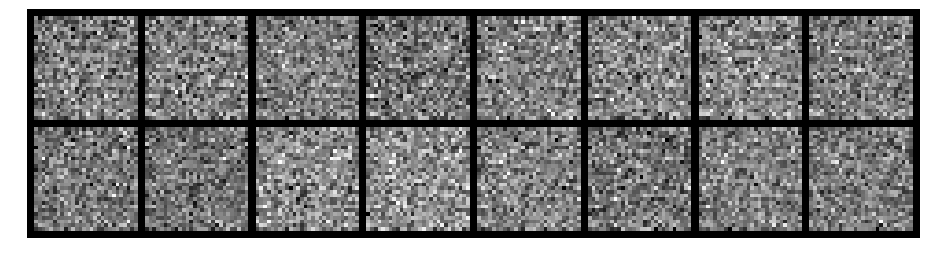

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3831, Generator Loss: 0.7175
D(x): 0.4899, D(G(z)): 0.4878


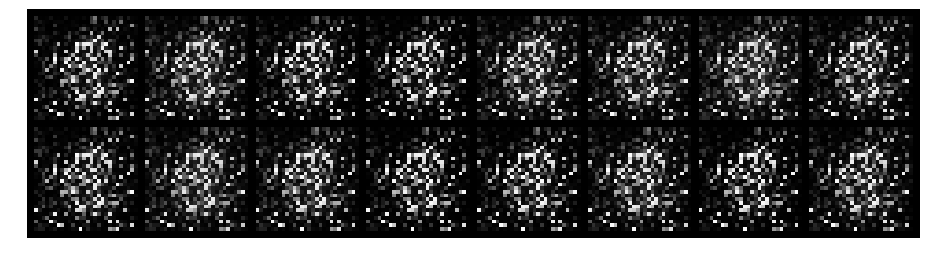

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.5185, Generator Loss: 4.5682
D(x): 0.8255, D(G(z)): 0.1849


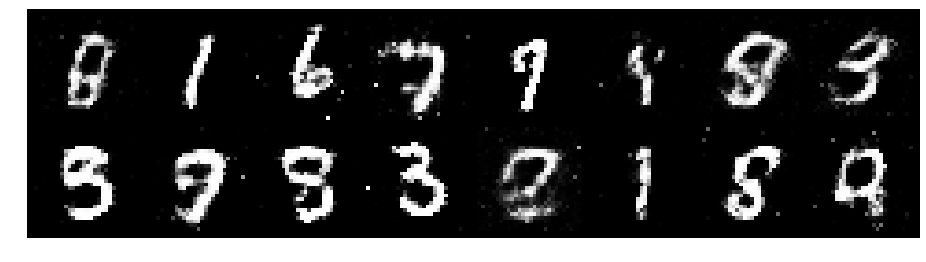

Epoch: [40/200], Batch Num: [0/600]
Discriminator Loss: 1.1748, Generator Loss: 1.1564
D(x): 0.5843, D(G(z)): 0.3874


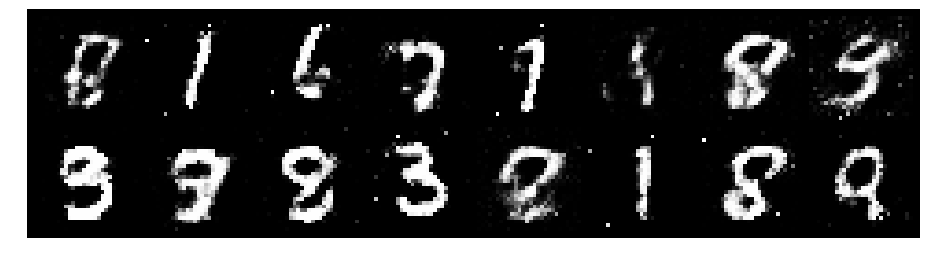

Epoch: [40/200], Batch Num: [300/600]
Discriminator Loss: 1.0203, Generator Loss: 1.4968
D(x): 0.6487, D(G(z)): 0.3407


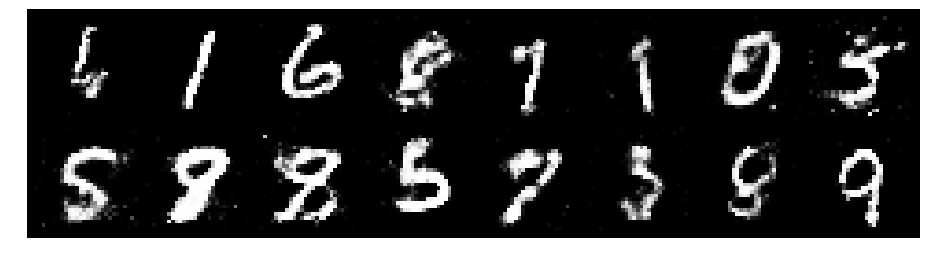

Epoch: [80/200], Batch Num: [0/600]
Discriminator Loss: 1.2518, Generator Loss: 0.8777
D(x): 0.5634, D(G(z)): 0.4505


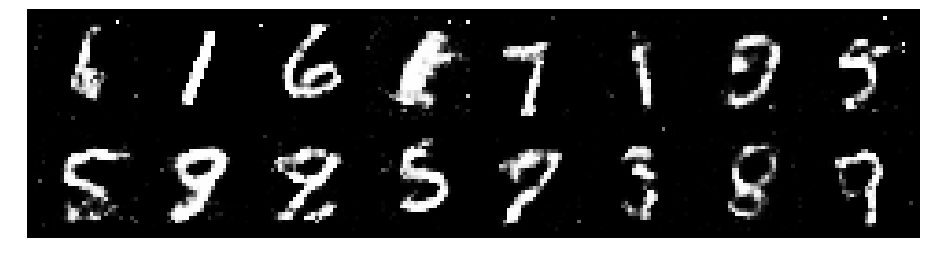

Epoch: [80/200], Batch Num: [300/600]
Discriminator Loss: 1.2575, Generator Loss: 0.8457
D(x): 0.5784, D(G(z)): 0.4338


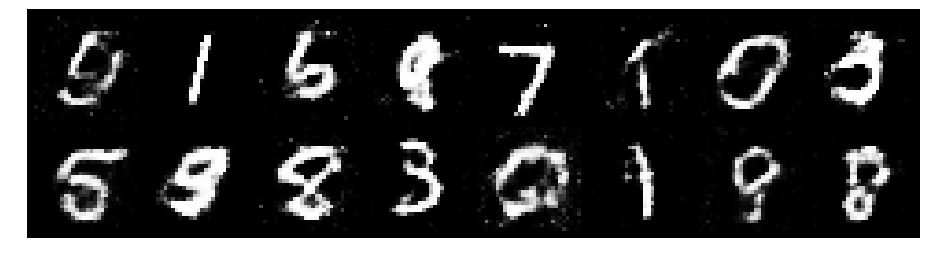

Epoch: [120/200], Batch Num: [0/600]
Discriminator Loss: 1.2601, Generator Loss: 0.8408
D(x): 0.5743, D(G(z)): 0.4574


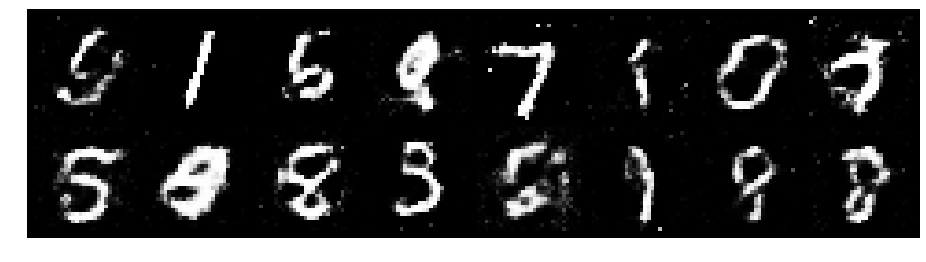

Epoch: [120/200], Batch Num: [300/600]
Discriminator Loss: 1.1481, Generator Loss: 0.9045
D(x): 0.5921, D(G(z)): 0.4291


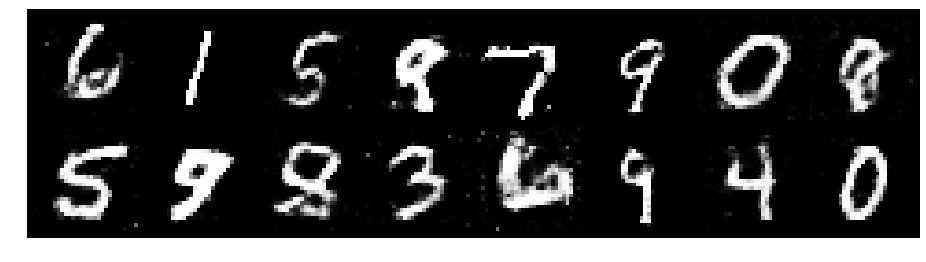

Epoch: [160/200], Batch Num: [0/600]
Discriminator Loss: 1.2462, Generator Loss: 0.8878
D(x): 0.5585, D(G(z)): 0.4409


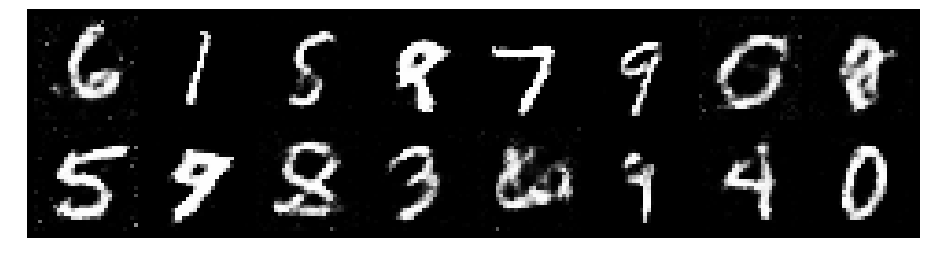

Epoch: [160/200], Batch Num: [300/600]
Discriminator Loss: 1.3169, Generator Loss: 0.9830
D(x): 0.5100, D(G(z)): 0.4069


In [32]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress every few batches
        if (epoch) % 40 == 0 and (n_batch) % 300 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )